In [68]:
import datetime
from datetime import date
from datetime import timedelta
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import CubicSpline

### Data Preparation

<AxesSubplot:>

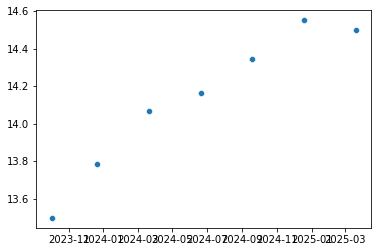

In [5]:
# Enter the prices and dates, the first one is spot

forward_prices = [13.497, 13.786, 14.069, 14.161, 14.345, 14.551, 14.498]
dates = [datetime.datetime.now().date(), date(2023, 12, 21), date(2024, 3, 21), 
         date(2024, 6, 20), date(2024, 9, 19), 
         date(2024, 12, 19),date(2025, 3, 20)]

sns.scatterplot(x=dates, y=forward_prices)

<AxesSubplot:>

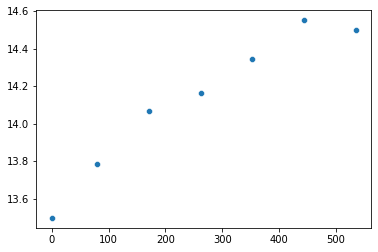

In [6]:
# Replace dates with dates remaining from today using list comprehension

days_from_now = [(i - datetime.datetime.now().date()).days for i in dates]

sns.scatterplot(x=days_from_now, y=forward_prices)

<AxesSubplot:>

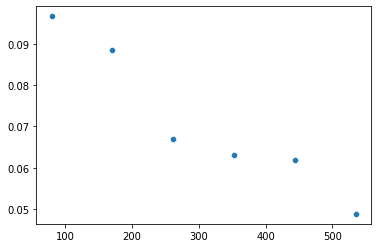

In [44]:
# Calculate implied rates with the exponential formula

implied_rates = [math.log(forward_prices[i] / forward_prices[0]) / days_from_now[i] * 365 
                 for i in range(1,len(forward_prices))]

sns.scatterplot(x=days_from_now[1:], y=implied_rates)

### Interpolate!

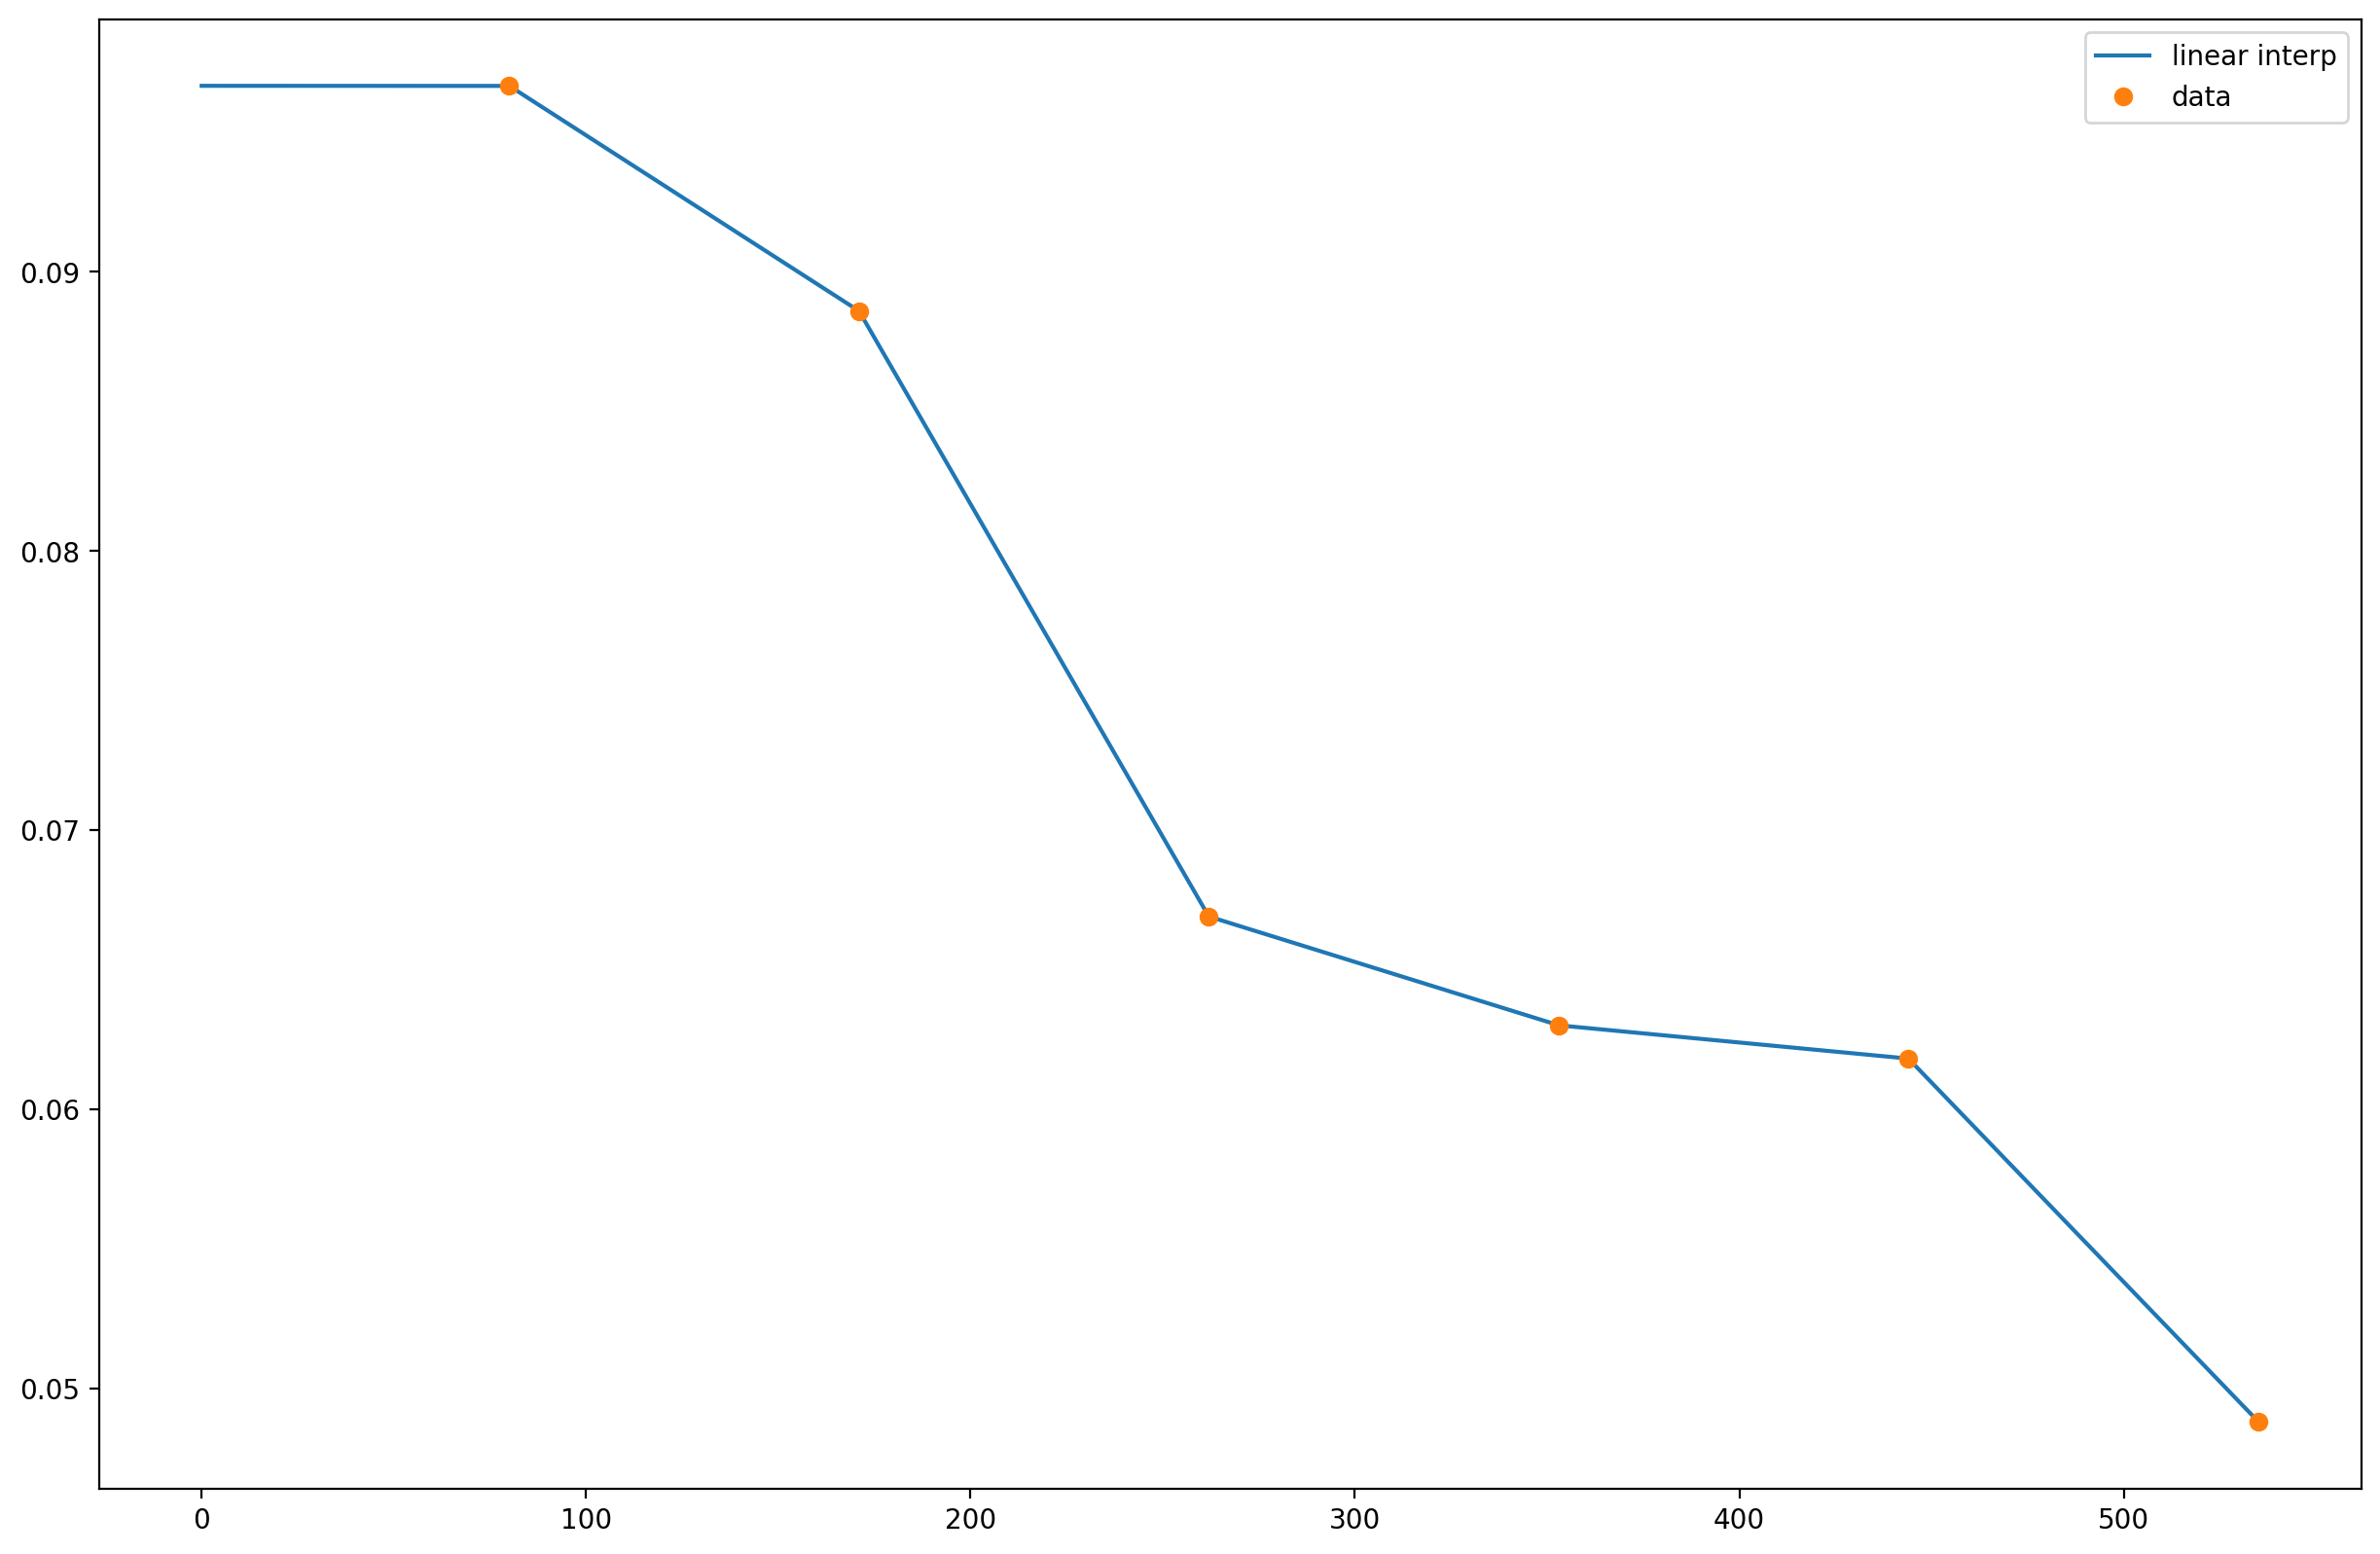

In [67]:
# Now - onto interpolation!

# First off: the most basic way - linear, using numpy (inferior way, but I want to highlight an alternative):

plt.figure(figsize=(15,10), dpi = 200)

xnew = np.linspace(0, max(days_from_now), num=10001)
ynew = np.interp(xnew, days_from_now[1:], implied_rates)

plt.plot(xnew, ynew, '-', label='linear interp')
plt.plot(days_from_now[1:], implied_rates, 'o', label='data')
plt.legend(loc='best')
plt.show()

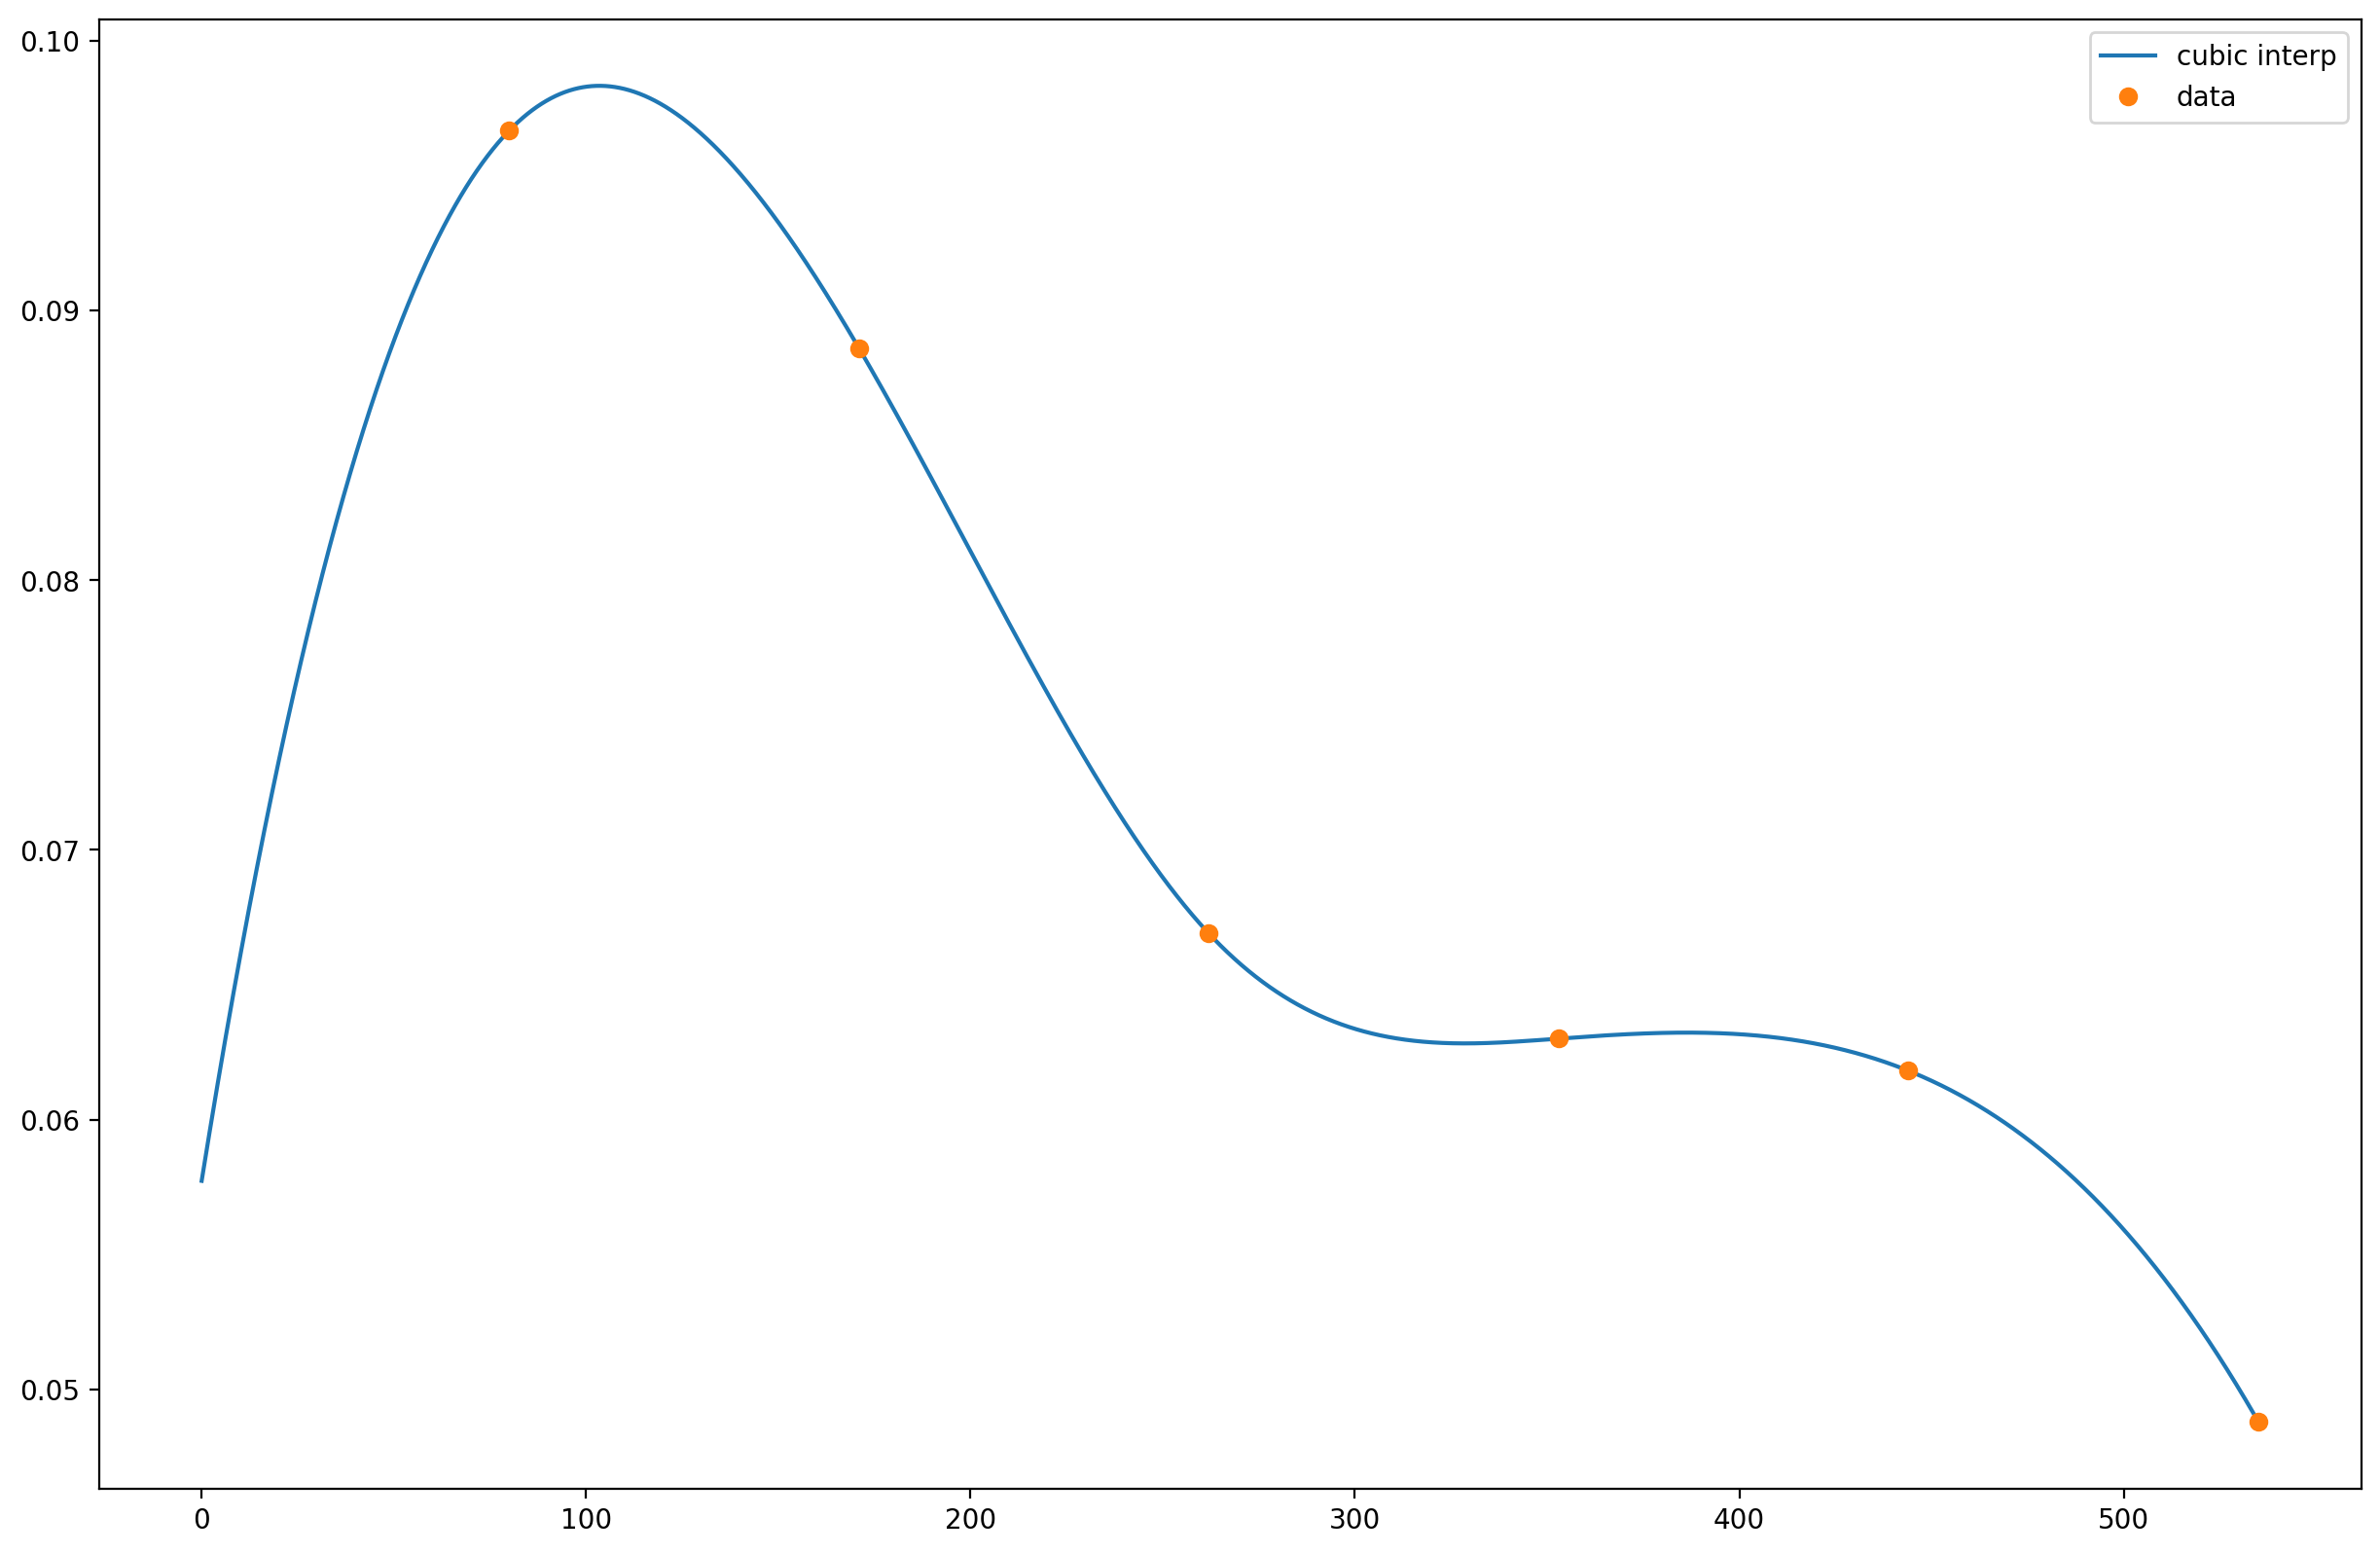

In [69]:
# Now, lets build a bit more advanced curve using cubic spline from scipy library

plt.figure(figsize=(15,10), dpi = 200)

spl = CubicSpline(days_from_now[1:], implied_rates)

xnew = np.linspace(0, max(days_from_now), num=10001)
plt.plot(xnew, spl(xnew), '-', label='cubic interp')

# One can cut the extrapolated parts with no effects to the curve shape!
# xnew_2 = np.linspace(days_from_now[1], max(days_from_now), num=10001)
# plt.plot(xnew_2, spl(xnew_2), '-', label='cubic interp (another)')

plt.plot(days_from_now[1:], implied_rates, 'o', label='data')
plt.legend(loc='best')
plt.show()

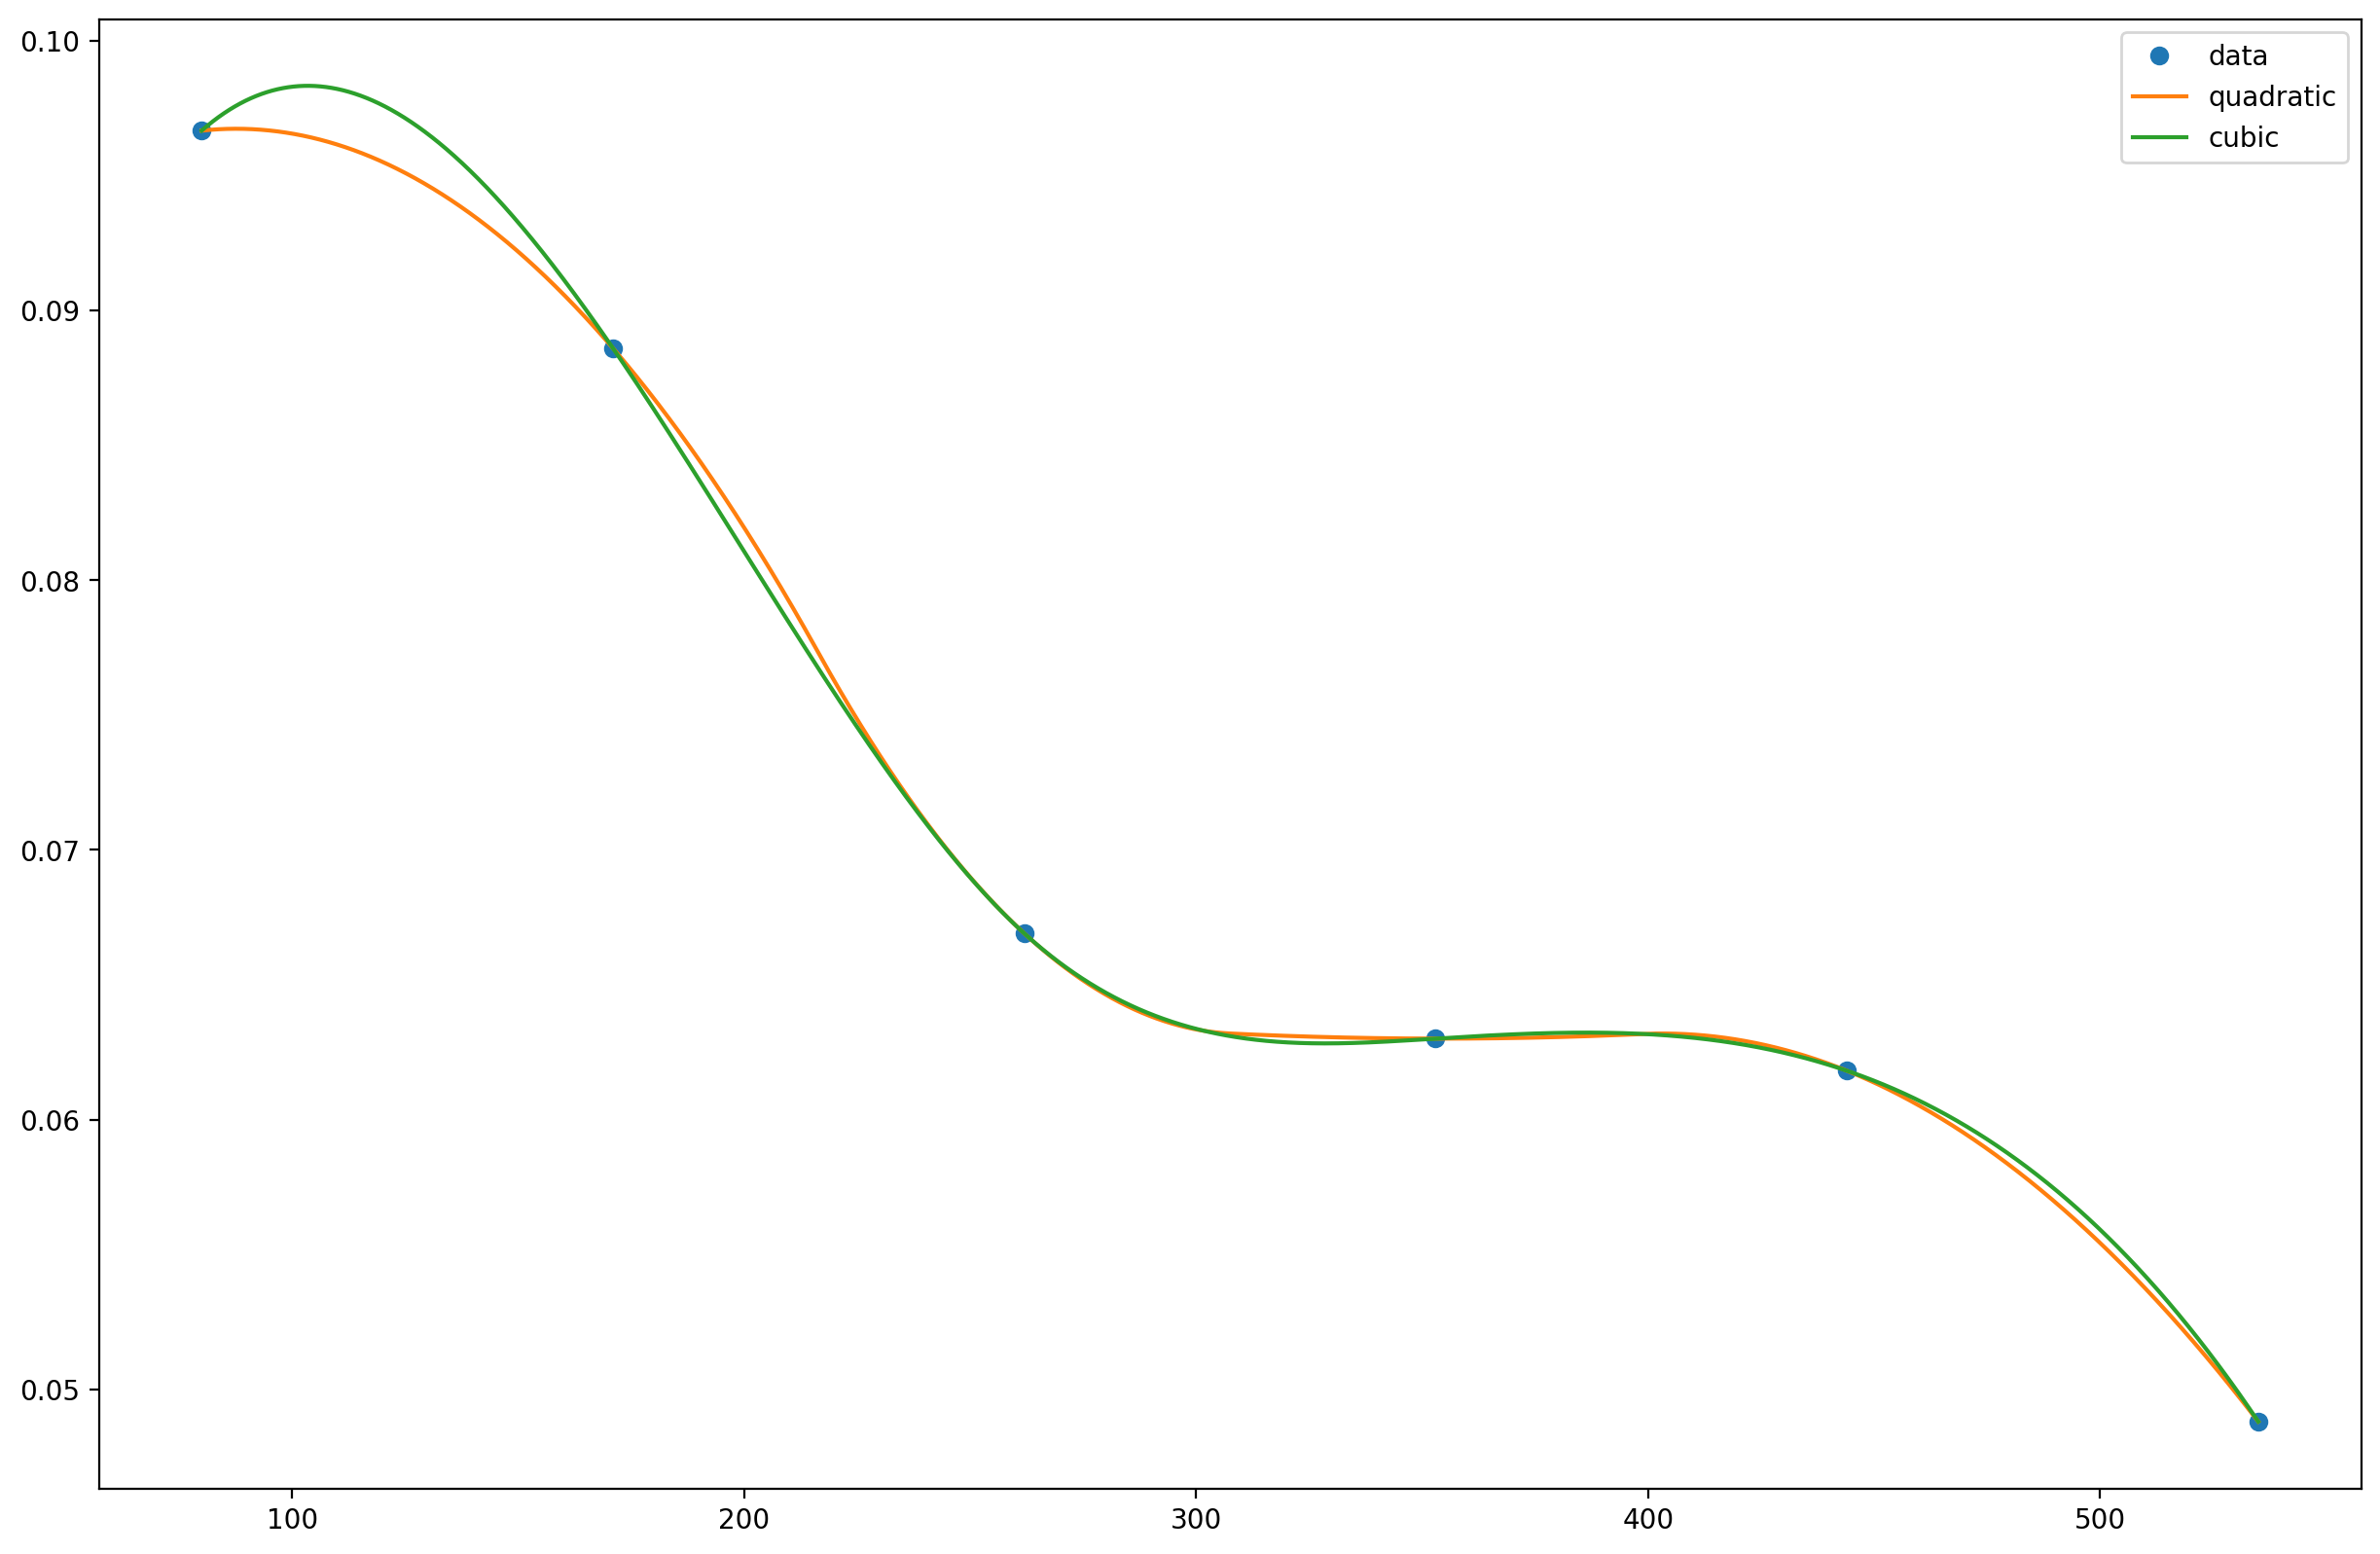

In [32]:
# However, we don't have to use cubic spline, alternative is quadratic one, which may perform better in certain cases!

plt.figure(figsize=(15,10), dpi = 200)

f = interpolate.interp1d(days_from_now[1:], implied_rates, kind = "quadratic")
q = interpolate.interp1d(days_from_now[1:], implied_rates, kind = "cubic")

xnew = np.linspace(days_from_now[1], max(days_from_now), num=10001)

ynew = f(xnew)
ynew_2 = q(xnew)

plt.plot(days_from_now[1:], implied_rates, 'o', label = "data")
plt.plot(xnew, ynew, '-', label = "quadratic")
plt.plot(xnew, ynew_2, '-', label ="cubic")
plt.legend(loc='best')
plt.show()

# General Rule of Thumb - the more degrees of the polynomial, the "wobblier" curve becomes

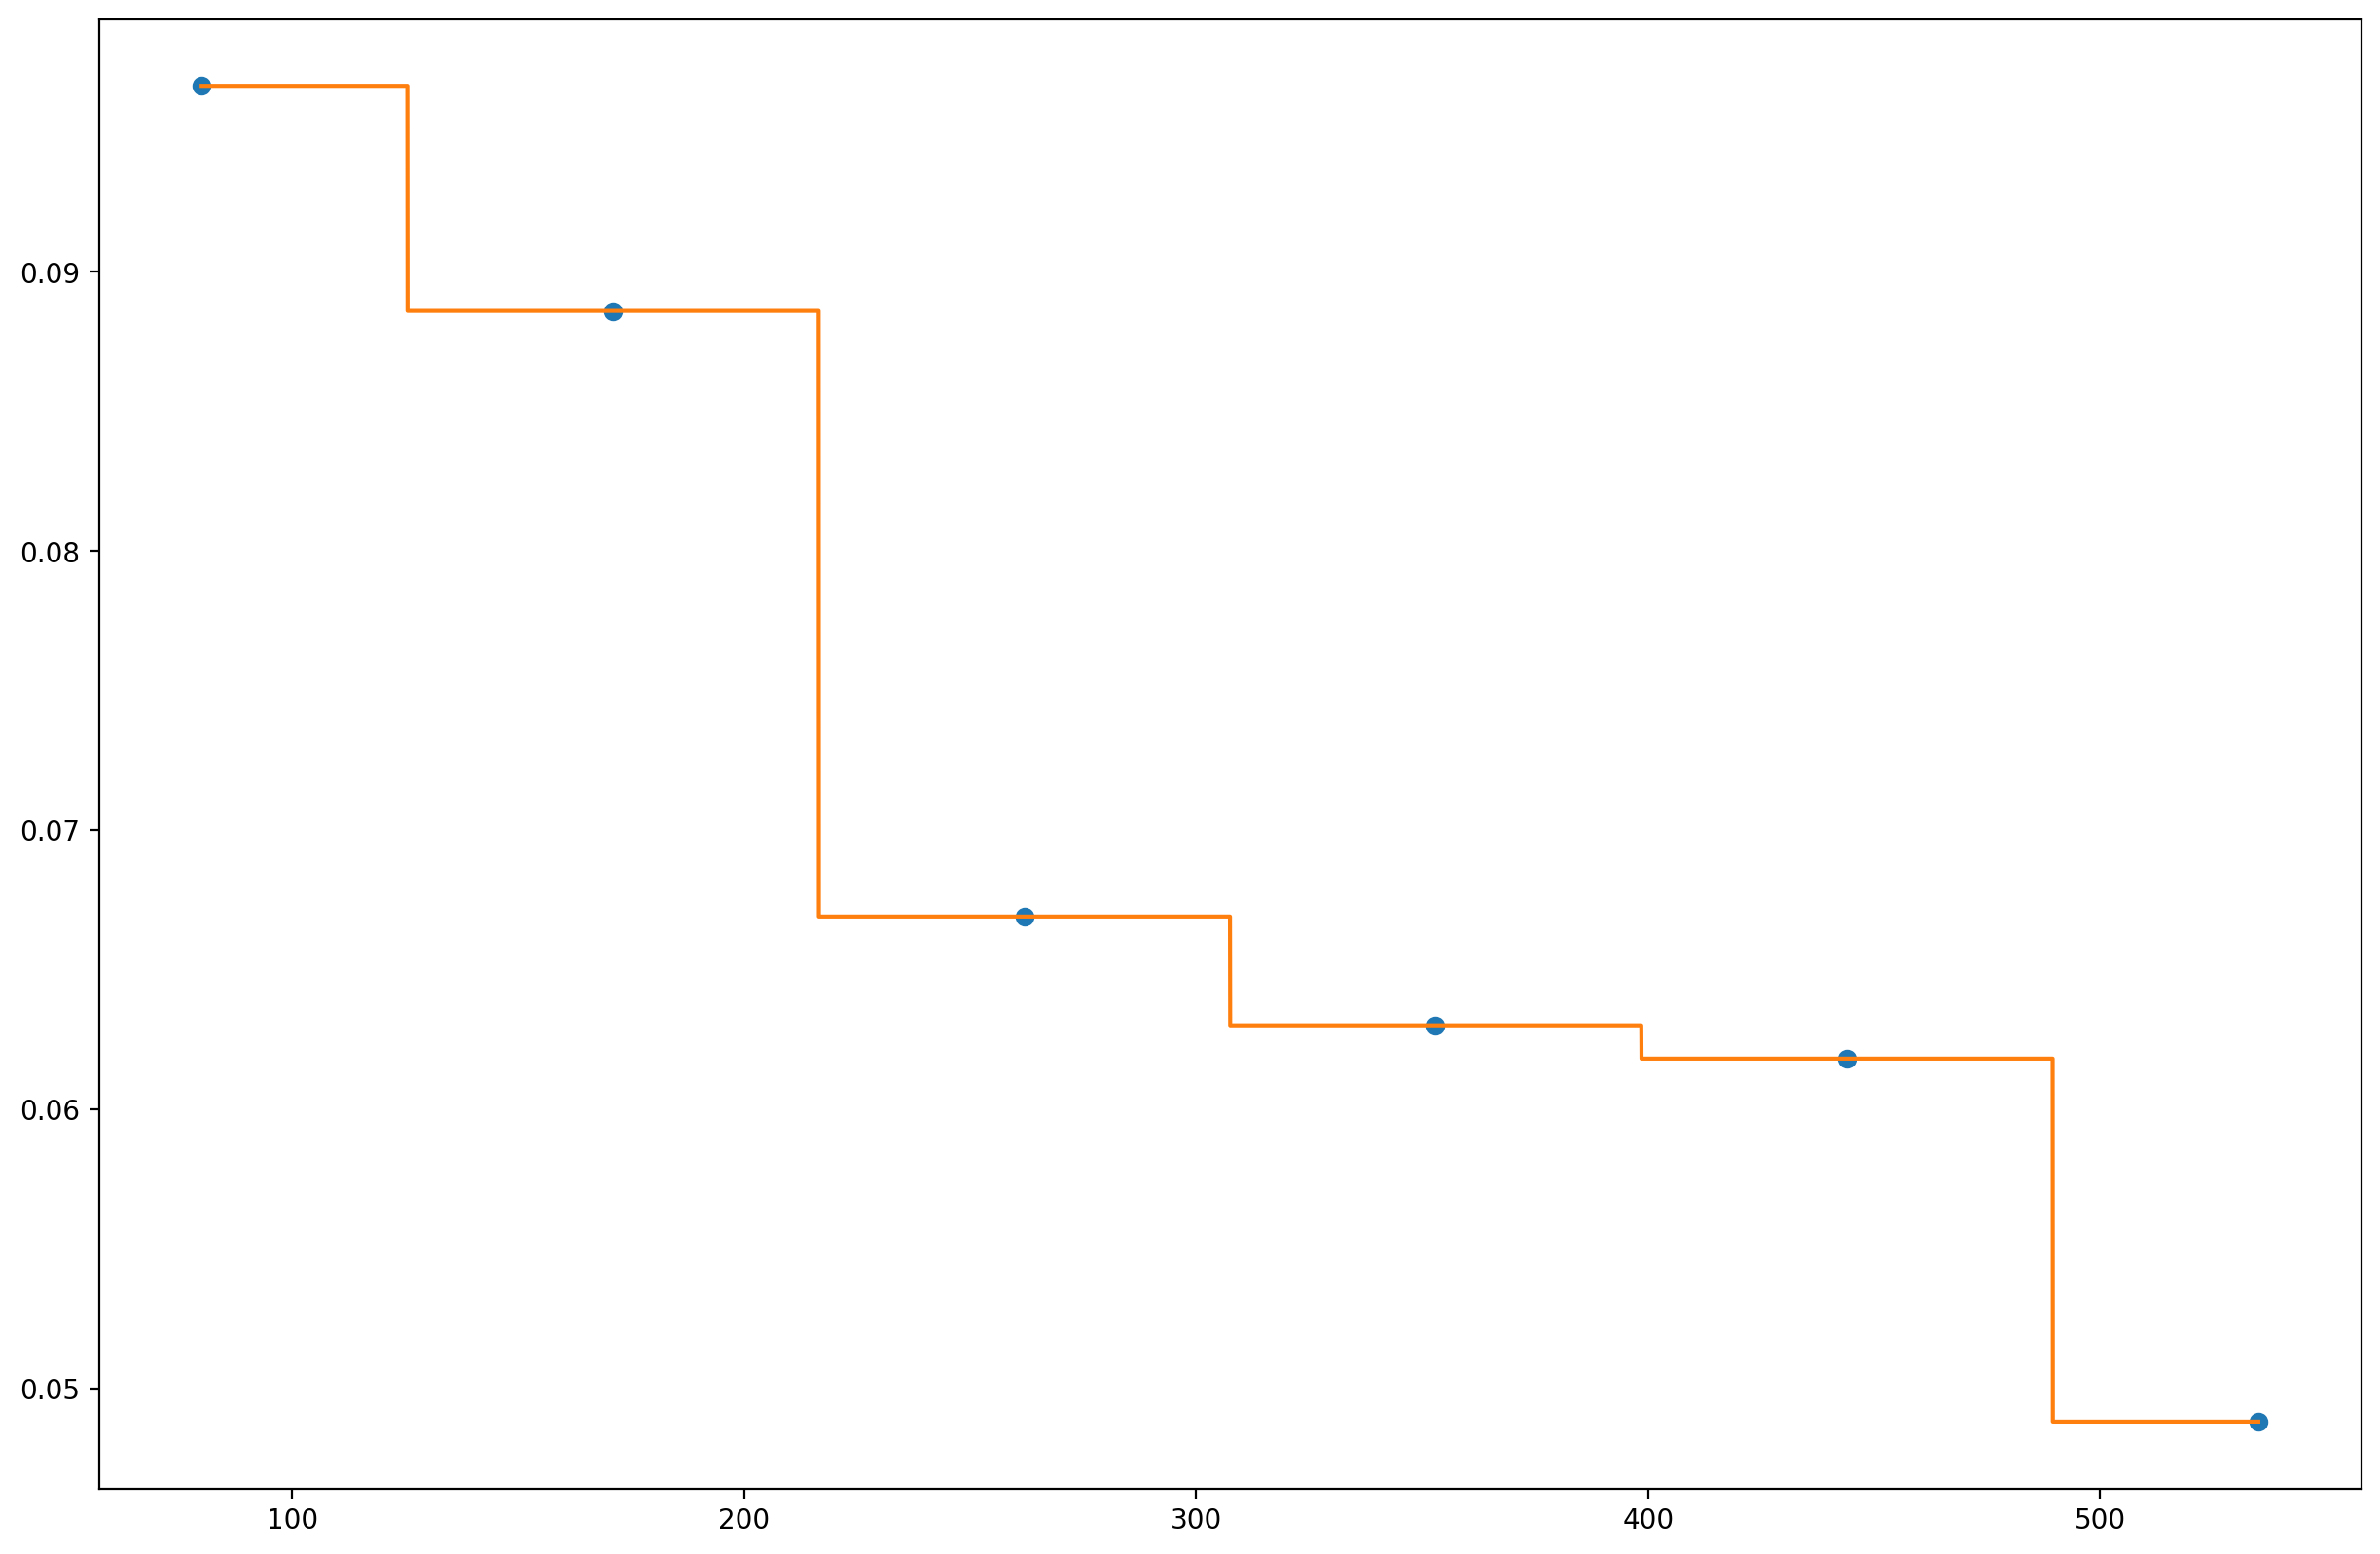

In [31]:
# Alternative ways of interpolation - limited use cases, but just for your knowledge
# Options include: zero, nearest, nearest-up, slinear, previous, next
plt.figure(figsize=(15,10), dpi = 200)
interp = interpolate.interp1d(days_from_now[1:], implied_rates, kind = "nearest")
xnew = np.linspace(days_from_now[1], max(days_from_now), num=10001)
ynew = interp(xnew)
plt.plot(days_from_now[1:], implied_rates, 'o')
plt.plot(xnew, ynew, '-')

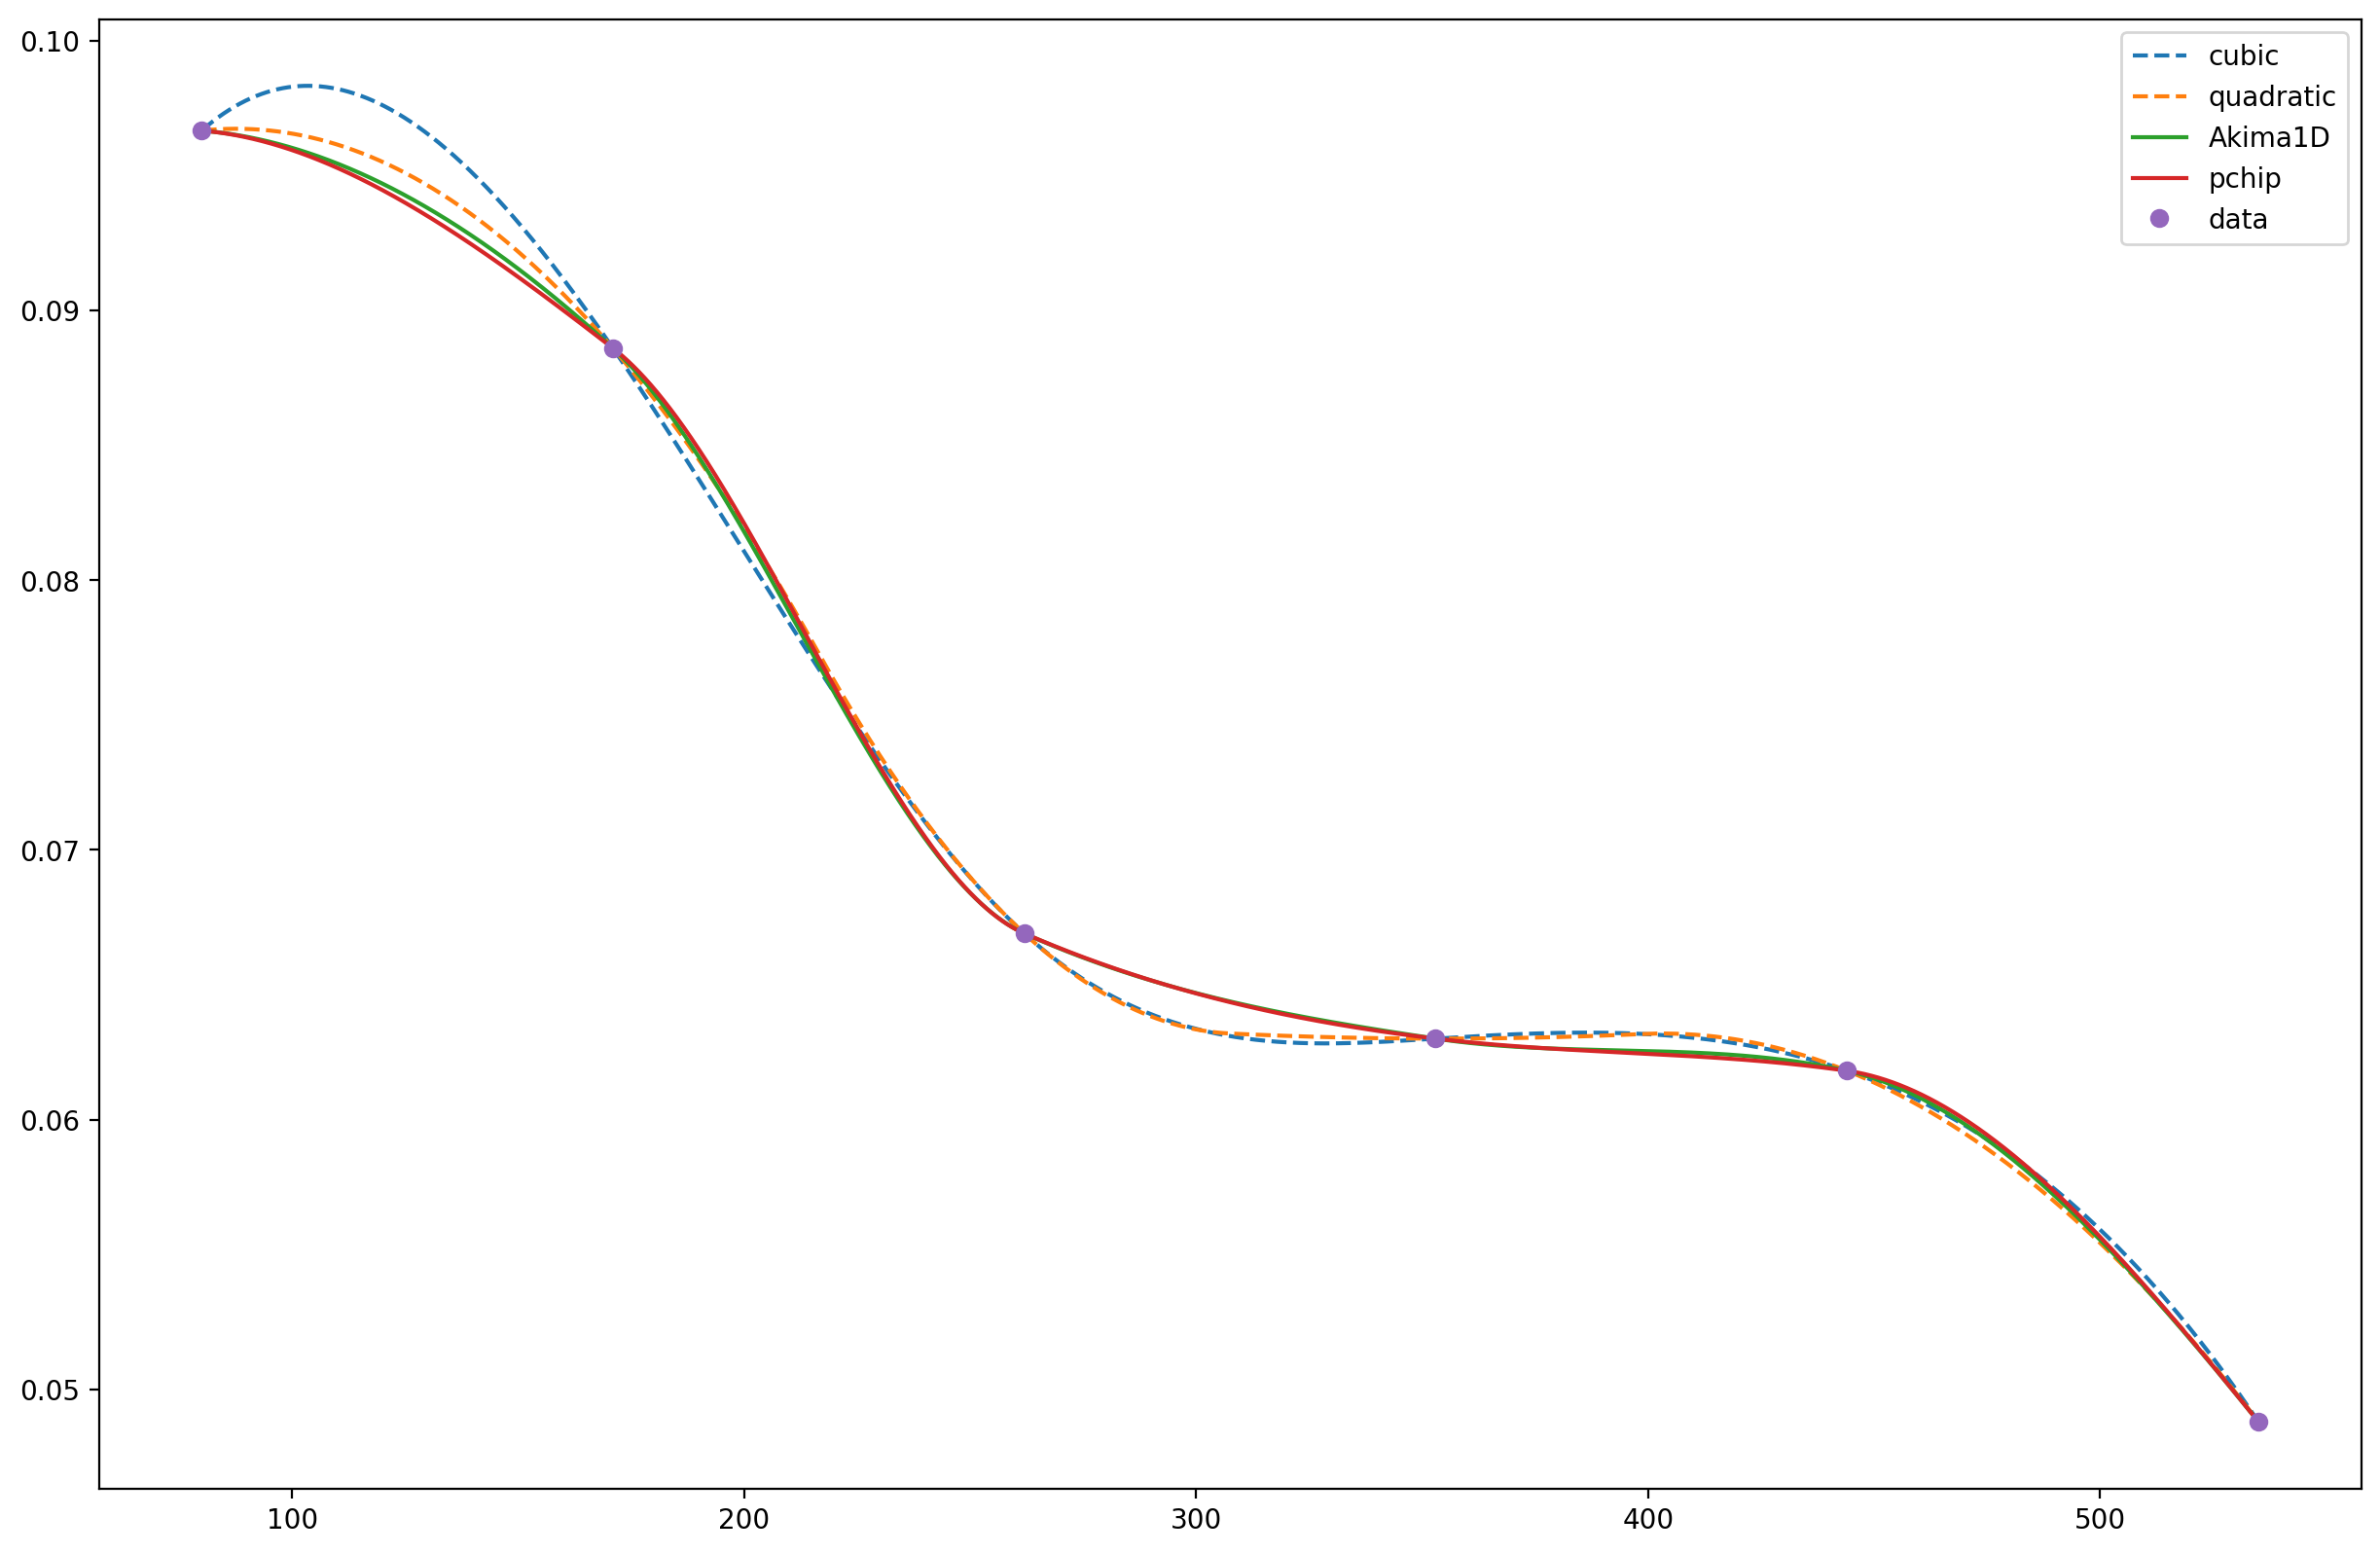

In [33]:
# But what if we want to get rid of the unnecessary "wobbling" of the cubic spline beyond just using quadratic?
# We can use monotone cubic interpolants, which are really similar to cubic splines
# but are differentiable up to 1st, not 2nd degree!
# These more advanced methods use harmonic mean of the 1st derivative to calculate intermediate values

plt.figure(figsize=(15,10), dpi = 200)

xnew = np.linspace(days_from_now[1], max(days_from_now), num=10001)
f = interpolate.interp1d(days_from_now[1:], implied_rates, kind = "quadratic")
ynew = f(xnew)

plt.plot(xnew, interpolate.CubicSpline(days_from_now[1:], implied_rates)(xnew), '--', label='cubic')
plt.plot(xnew, ynew, '--', label = "quadratic")
plt.plot(xnew, interpolate.Akima1DInterpolator(days_from_now[1:], implied_rates)(xnew), '-', label='Akima1D')
plt.plot(xnew, interpolate.PchipInterpolator(days_from_now[1:], implied_rates)(xnew), '-', label='pchip')
plt.plot(days_from_now[1:], implied_rates, 'o', label = "data")

plt.legend(loc='best')
plt.show()

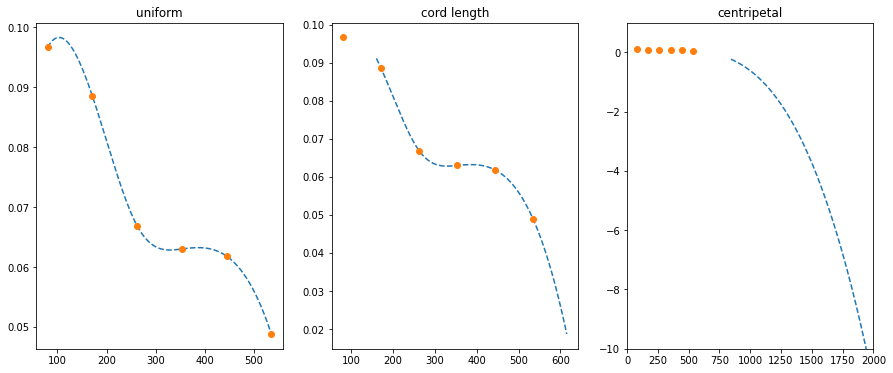

In [66]:
# Now consider this: we can affect splines' behaviour by introducing
# some "hyperparameters" of how we weight values of x:

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
parametrizations = ['uniform', 'cord length', 'centripetal']

# three methods used

# uniform
u_unif = days_from_now[1:]

# cord length (points are parametrized to the cumulative length of linear interpolation segments)
p = np.stack((days_from_now[1:], implied_rates))
dp = p[:, 1:] - p[:, :-1]
l = (dp**2).sum(axis=0)        # squares of lengths of 2-vectors between points
u_cord = np.sqrt(l).cumsum() 
u_cord = np.r_[0, u_cord]

# centripetal (similar to cord, but algorithm will minimize distance between two points more agressively,
# but still takes into account the shortest route)
u_c = np.r_[0, np.cumsum((dp**2).sum(axis=0)**0.25)]


for j, u in enumerate([u_unif, u_cord, u_c]):
    spl = interpolate.make_interp_spline(u, p, axis=1)    # note p is a 2D array

    uu = uu = np.linspace(days_from_now[1], max(days_from_now), num=10001)
    xx, yy = spl(uu)

    ax[j].plot(xx, yy, '--')
    ax[j].plot(p[0, :], p[1, :], 'o')
    ax[j].set_title(parametrizations[j])
plt.xlim(0,2000)
plt.ylim(-10,1)
plt.show()

In [ ]:
# Possible extensions - B-splines: I do not have an understanding deep enough to explain it, plus on my tested
# use-cases the results are the same to the regular splines